<a href="https://colab.research.google.com/github/Klauszhao/GameCode/blob/master/modelStacking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 模型融合方式任意，并结合Task5给出你的最优结果。

时间：2天

例如Stacking融合，用你目前评分最高的模型作为基准模型，和其他模型进行stacking融合，得到最终模型及评分结果。

### StackingCVClassifier

[StackingCVClassifier](http://rasbt.github.io/mlxtend/user_guide/classifier/StackingCVClassifier/) 是一个交叉验证的集成框架，在一般应用当中，常常需要将数据集划分几份，即采用K折样本划分的方式。一般推荐StackingCVClassifier 而不使用StackingClassifier。

### 模型融合采用 Stacking 方法

- 1、依据 Task5 提取 XGBClassifier、LGBMClassifier、RFClassifier 作为基模型，采用 LogisticRegressionCV 作为次模型，
- 2、根据Task5 网格搜索后得到的模型最优参数作为模型默认值来训练模型，然后通过stacking 方法融合

In [0]:
from mlxtend.classifier import StackingCVClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.metrics import *
from sklearn import metrics
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale


import warnings
warnings.filterwarnings('ignore')

In [20]:
# 连接 Google colab 的云盘，数据集存放在云盘中，如果你的数据集不在云盘中，这段代码可以注释掉，从自己本地读取数据集
from google.colab import drive
drive.mount('/content/gdrive')
!ls 'gdrive/My Drive/Data'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
aspect-extract	dataAnalyse  dataProcessByTwoTask.csv  zhaopin


In [21]:
# 读取数据
filePath = 'gdrive/My Drive/Data/dataProcessByTwoTask.csv'
data = pd.read_csv(filePath,encoding='gbk')

train_data, test_data = train_test_split(data, test_size=0.3, random_state=2018)
print("train_data",train_data.shape)
print("test_data",test_data.shape)

y_train = train_data['status']
x_train = train_data.drop(['status'],axis =1)

y_test = test_data['status']
x_test = test_data.drop(['status'],axis =1)

### 归一化模型

x_train_scale =minmax_scale(x_train)
x_test_scale =minmax_scale(x_test)

train_data (3096, 70)
test_data (1327, 70)


### 1、根据最优参数训练模型
XGBClassifier、RFClassifier 作为基模型，采用 LogisticRegressionCV

In [22]:
## LR

LR = LogisticRegression(C=1)
#LR.fit(x_train_scale,y_train)
print(" LR 训练结束")

# RF
#rf=RandomForestClassifier(n_estimators=100,max_depth=7,min_samples_split=80,min_samples_leaf=10)

RF = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=50,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#RF.fit(x_train_scale,y_train)
print(" RF 训练结束")
# XGBClassifier

# XGB = XGBClassifier(learning_rate =0.1, n_estimators=180, max_depth=3, min_child_weight=3, 
#                     gamma=0.4, subsample=0.5, colsample_bytree=1, reg_alpha=1,random_state=2018, 
#                     objective= 'binary:logistic', nthread=2,scale_pos_weight=1, seed=27)


XGB = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=3, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=2018,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
XGB.fit(x_train_scale,y_train)
print(" XGB 训练结束")

 LR 训练结束
 RF 训练结束
 XGB 训练结束


In [0]:
stackingModel = StackingCVClassifier(classifiers=[XGB, RF],
                                   use_probas=True, 
                                   meta_classifier=LR,
                                   cv=5
                                   )


## 评价方法
def Eva(clf, x_test, y_test):
    y_predic = clf.predict(x_test)
    y_proba = clf.predict_proba(x_test)

    acc = metrics.accuracy_score(y_test, y_predic)
    p = metrics.precision_score(y_test, y_predic)
    r = metrics.recall_score(y_test, y_predic)
    f1 = metrics.f1_score(y_test, y_predic)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_proba[:, 1])
    auc = metrics.auc(fpr, tpr)
    return acc, p, r, f1, fpr, tpr, auc
  
## 绘图函数

def plot_roc(fprs, tprs, aucs, title):
    plt.figure()
    lw = 2
    for i, name in enumerate(models):
        plt.plot(fprs[i], tprs[i], lw=lw, label='{0} (AUC:{1:0.2f})'.format(name, aucs[i]))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic of '+title)
    plt.legend(loc="lower right")
    plt.show()

In [32]:
count = 0 
for x in y_train:
  if np.isnan(x) :
    count = count +1
print(count)

0


name= LR
name= RF
name= XGB
           Model dataset  Accuracy  Precision    Recall  F1 score       AUC
0             LR   train  0.801357   0.738019  0.302356  0.428969  0.809379
2             RF   train  0.824289   0.901460  0.323298  0.475915  0.898176
4            XGB   train  0.853359   0.850679  0.492147  0.623549  0.916271
6  StackingModel   train  0.802006   0.000000  0.000000  0.444846  0.000000
           Model dataset  Accuracy  Precision    Recall  F1 score       AUC
1             LR    test  0.785983   0.668394  0.369628  0.476015  0.773569
3             RF    test  0.773173   0.690476  0.249284  0.366316  0.779378
5            XGB    test  0.768651   0.602941  0.352436  0.444846  0.782417
6  StackingModel    test  0.769398   0.000000  0.000000  0.444846  0.000000


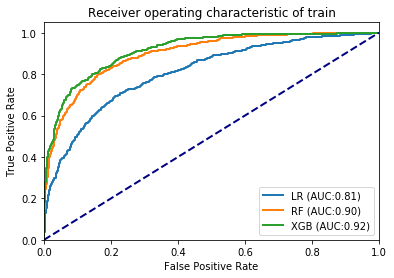

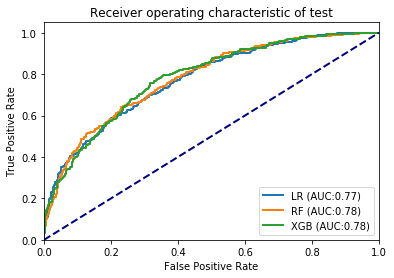

In [44]:
models = {'LR': LR,
          'RF': RF,
          'XGB': XGB}

# ,
#          'StackingModel': stackingModel  这个放到 models后，在下面的代码中 clf.fit(x_train_scale, y_train)  老报错，换一种方式来处理

df_result_train = pd.DataFrame(columns=('Model', 'dataset', 'Accuracy', 'Precision', 'Recall', 'F1 score', 'AUC'))
df_result_test = pd.DataFrame(columns=('Model', 'dataset', 'Accuracy', 'Precision', 'Recall', 'F1 score', 'AUC'))

row = 0
fprs_train = []
tprs_train = []
aucs_train = []
fprs_test = []
tprs_test = []
aucs_test = []



for name, clf in models.items():
  print('name=',name)
  clf.fit(x_train_scale, y_train)
  acc, p, r, f1, fpr_train, tpr_train, auc_train = Eva(clf, x_train_scale, y_train)
  fprs_train.append(fpr_train)
  tprs_train.append(tpr_train)
  aucs_train.append(auc_train)
  df_result_train.loc[row] = [name, 'train', acc, p, r, f1, auc_train]
  row += 1

  acc, p, r, f1, fpr_test, tpr_test, auc_test = Eva(clf, x_test_scale, y_test)
  fprs_test.append(fpr_test)
  tprs_test.append(tpr_test)
  aucs_test.append(auc_test)
  df_result_test.loc[row] = [name, 'test', acc, p, r, f1, auc_test]
  row += 1

  
scores = cross_val_score(clf, x_train_scale, y_train,cv=3, scoring='accuracy')

df_result_train.loc[row] = ["StackingModel", 'train', scores.mean(), 0, 0, f1, 0]


scores = cross_val_score(clf, x_test_scale, y_test,cv=3, scoring='accuracy')

df_result_test.loc[row] = ["StackingModel", 'test', scores.mean(), 0, 0, f1, 0]

# print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
#           % (scores.mean(), scores.std(), label))

print(df_result_train)

print(df_result_test)

plot_roc(fprs_train, tprs_train, aucs_train, 'train')
plot_roc(fprs_test, tprs_test, aucs_test, 'test')